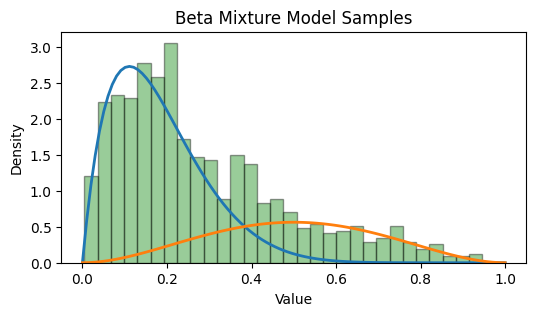

In [7]:
# generate n random data from beta mixture model
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def generate_beta_mixture(n, weights, a_params, b_params):
    """
    Generate n random samples from a beta mixture model.

    Parameters:
    n (int): Number of samples to generate.
    weights (list): List of weights for each beta component.
    a_params (list): List of 'a' parameters for each beta component.
    b_params (list): List of 'b' parameters for each beta component.

    Returns:
    np.ndarray: Array of generated samples.
    """
    # Normalize weights
    weights = np.array(weights)
    weights /= weights.sum()

    # Choose components based on weights
    components = np.random.choice(len(weights), size=n, p=weights)

    # Generate samples
    samples = np.array([beta.rvs(a_params[i], b_params[i]) for i in components])

    return samples
if __name__ == "__main__":
    # Parameters for the beta mixture model
    weights = [0.7, 0.3]
    a_params = [2, 3]
    b_params = [9, 3]

    # Generate samples
    n_samples = 1000
    samples = generate_beta_mixture(n_samples, weights, a_params, b_params)

    # Plot histogram of the samples
    fig = plt.figure(figsize=(6, 3))
    plt.hist(samples, bins=30, density=True, alpha=0.4, \
             color='g', edgecolor='black')

    # Plot the individual beta components for reference
    x = np.linspace(0, 1, 100)
    for w, a, b in zip(weights, a_params, b_params):
        plt.plot(x, w * beta.pdf(x, a, b), lw=2)

    plt.title('Beta Mixture Model Samples')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()
